In [12]:
import pandas as pd
data = pd.read_csv('../data_train/stringtie_tss_labeled.csv')
print("StringTie TSS",data['label'].value_counts())
print("StringTie TSS",data['label'].value_counts(normalize=True))
print(data['chrom'].value_counts())
data_true = data[data['label'] == 1].sample(frac=1).head(5)
print("True TSS")
print(data_true[['chrom', 'position', 'delta_coverage' , 'read_start_density']])
data_false = data[data['label'] == 0].sample(frac=1).head(5)
print("False TSS")
print(data_false[['chrom', 'position', 'delta_coverage' , 'read_start_density']])
pdata = data[data['chrom'] == 'chr15']
print(pdata[['chrom', 'position', 'label']].iloc[:26])

data = pd.read_csv('../data_train/stringtie_tes_labeled.csv')
print("StringTie TES",data['label'].value_counts())
print("StringTie TES",data['label'].value_counts(normalize=True))
print(data['chrom'].value_counts())
data = pd.read_csv('../data_train/isoquant_tss_labeled.csv')
print("IsoQuant TSS",data['label'].value_counts())
print("IsoQuant TSS",data['label'].value_counts(normalize=True))
data = pd.read_csv('../data_train/isoquant_tes_labeled.csv')
print("IsoQuant TES",data['label'].value_counts())
print("IsoQuant TES",data['label'].value_counts(normalize=True))


# print minimum 5 and maximum 5 delta coverage rows

# print(data.loc[data['delta_coverage'].idxmax(), ['chrom', 'position', 'delta_coverage']])
# print(data.loc[data['delta_coverage'].idxmin(), ['chrom', 'position', 'delta_coverage']])

# # print five chromosomes and positions with label 1
# print(data.loc[data['label'] == 1, ['chrom', 'position', 'delta_coverage']].sample(frac=1).head(5))
# print(data.columns)

StringTie TSS label
0    6851
1    5639
Name: count, dtype: int64
StringTie TSS label
0    0.548519
1    0.451481
Name: proportion, dtype: float64
chrom
chr1          1248
chr2           853
chr19          829
chr17          779
chr3           711
chr12          701
chr11          693
chr6           632
chr7           626
chr5           585
chr16          582
chr9           510
chr14          446
chr4           446
chr10          445
chr15          412
chr8           408
chrX           373
chr22          338
chr20          306
chr13          247
chr18          164
chr21          131
chrY            10
GL000195.1       4
GL000205.2       4
KI270742.1       2
GL000218.1       1
KI270721.1       1
GL000219.1       1
GL000224.1       1
GL000194.1       1
Name: count, dtype: int64
True TSS
      chrom  position  delta_coverage  read_start_density
6226  chr19  38619186           20947                 333
3160  chr13  32586455             197                   3
292    chr1  32650591         

In [8]:
import os
import pandas as pd
from glob import glob

# Paths
REPORTS_DIR = "../out/reports"
OUTPUT_MD = os.path.join(REPORTS_DIR, "metrics_summary.md")

# Model variants we expect in filenames
MODELS = ["xgboost", "randomforest"]
SITE_TYPES = ["tss", "tes"]
TOOLS = ["stringtie", "isoquant"]

results = []

# Search for all metrics summary files
for site_type in SITE_TYPES:
    for tool in TOOLS:
        for model in MODELS:
            path = os.path.join(REPORTS_DIR, site_type, f"{tool}_{model}_metrics_summary.txt")
            if not os.path.exists(path):
                print(f"⚠️ No metrics file found for {tool} {model} on {site_type}. Skipping.")
                continue

            metrics = {
                "Tool": tool,
                "Site Type": site_type,
                "Model": model
            }
            with open(path) as f:
                lines = f.readlines()

                # Track confusion matrix separately
                confusion = {}

                for i, line in enumerate(lines):
                    line = line.strip()
                    if not line:
                        continue
                    if line.startswith("confusion_matrix"):
                        for j in range(1, 5):
                            if i + j < len(lines):
                                subline = lines[i + j].strip()
                                if ":" in subline:
                                    subkey, subval = subline.split(":", 1)
                                    confusion[subkey.strip()] = int(subval.strip())
                        continue
                    if ":" in line:
                        key, value = line.split(":", 1)
                        key = key.strip().lower()
                        try:
                            metrics[key] = float(value.strip())
                        except ValueError:
                            continue
                
                metrics.update({
                    "TP": confusion.get("TP", 0),
                    "FP": confusion.get("FP", 0),
                    "FN": confusion.get("FN", 0),
                    "TN": confusion.get("TN", 0)
                })
                # Class 1 (positive)
                tp = metrics["TP"]
                fp = metrics["FP"]
                fn = metrics["FN"]
                tn = metrics["TN"]

                prec_1 = tp / max(tp + fp, 1)
                rec_1  = tp / max(tp + fn, 1)
                f1_1   = 2 * prec_1 * rec_1 / max(prec_1 + rec_1, 1)

                # Class 0 (negative)
                prec_0 = tn / max(tn + fn, 1)
                rec_0  = tn / max(tn + fp, 1)
                f1_0   = 2 * prec_0 * rec_0 / max(prec_0 + rec_0, 1)

                metrics.update({
                    "precision_class_1": prec_1,
                    "recall_class_1": rec_1,
                    "f1_class_1": f1_1,
                    "precision_class_0": prec_0,
                    "recall_class_0": rec_0,
                    "f1_class_0": f1_0,
                })

                # Add class-wise results
                
            results.append(metrics)

# Create markdown report
if results:
    df = pd.DataFrame(results)
    df = df[[
        "Tool", "Site Type", "Model",
        "accuracy", "precision", "recall", "f1", "aupr", "auc",
        "TP", "FP", "FN", "TN",
        "precision_class_1", "recall_class_1", "f1_class_1",
        "precision_class_0", "recall_class_0", "f1_class_0"
    ]]

    os.makedirs(REPORTS_DIR, exist_ok=True)
    with open(OUTPUT_MD, "w") as f:
        f.write("# Combined Model Evaluation Summary\n\n")
        f.write(df.to_markdown(index=False))
    print(f"✅ Markdown summary written to {OUTPUT_MD}")
else:
    print("⚠️ No metrics files found. Nothing to summarize.")


✅ Markdown summary written to ../out/reports/metrics_summary.md


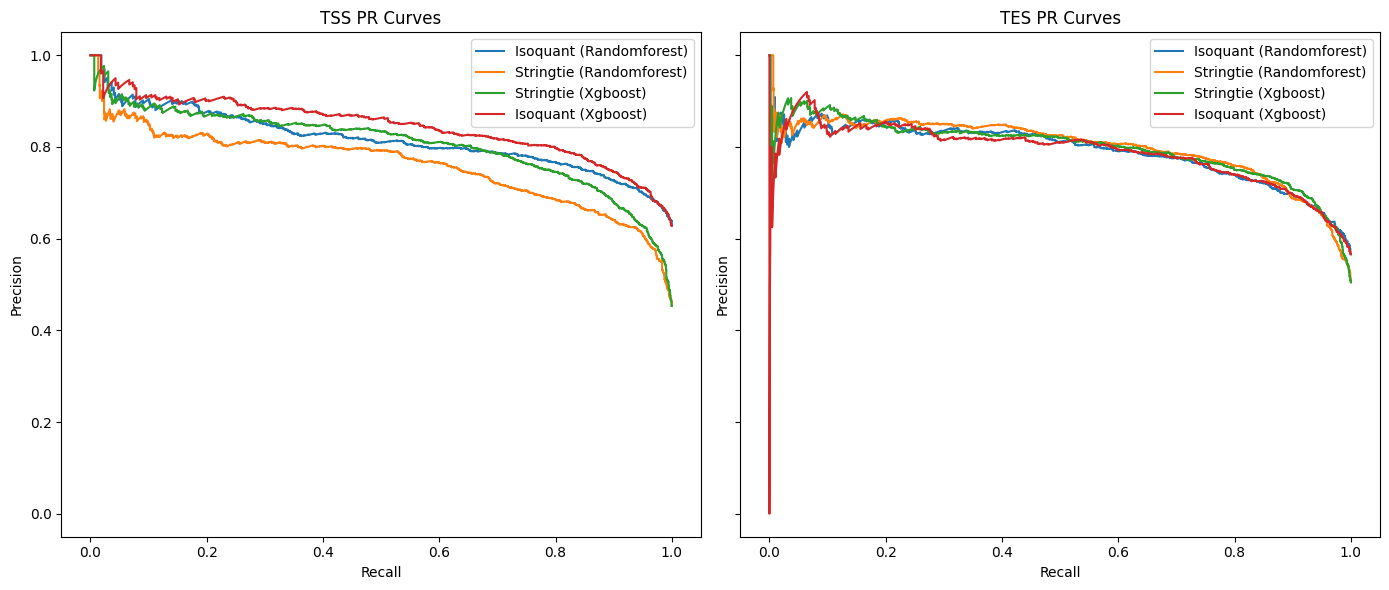

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import glob

# Get PR curve data CSVs
tss_files = glob.glob("../out/plots/tss/*_pr_data.csv")
tes_files = glob.glob("../out/plots/tes/*_pr_data.csv")

# Set up subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot TSS
for file in tss_files:
    df = pd.read_csv(file)
    label = file.split("/")[-1].replace("_pr_curve_pr_data.csv", "").replace("_", " (").title()
    axs[0].plot(df["recall"], df["precision"], label=f"{label})")
axs[0].set_title("TSS PR Curves")
axs[0].set_xlabel("Recall")
axs[0].set_ylabel("Precision")
axs[0].legend()

# Plot TES
for file in tes_files:
    df = pd.read_csv(file)
    label = file.split("/")[-1].replace("_pr_curve_pr_data.csv", "").replace("_", " (").title()
    axs[1].plot(df["recall"], df["precision"], label=f"{label})")
axs[1].set_title("TES PR Curves")
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].legend()

# Save and show
plt.tight_layout()
plt.savefig("../out/plots/pr_curves_tss_tes_subplots.png")
plt.show()


In [14]:
data = pd.read_csv('../data_train/stringtie_tss_labeled.csv')
all_chromosomes = data['chrom'].unique()
train_chromomes = ['chr'+str(i) for i in range(1, 15)]
validation_chromosomes = [chrom for chrom in all_chromosomes if chrom not in train_chromomes]
# write validation chromosomes in a file - as a list
with open('../data_train/validation_chromosomes.txt', 'w') as f:
    for chrom in validation_chromosomes:
        f.write(f"{chrom}\n")



In [19]:
pred_data = pd.read_csv('../out/predictions/stringtie_xgboost_merged.tsv', sep='\t')
pred_data = pred_data[['chrom', 'position', 'prediction']]
print(pred_data['chrom'].value_counts())
pred_data[pred_data['chrom'] == 'chrY']

chrom
chr19         1576
chr17         1462
chr16         1090
chr15          798
chrX           736
chr22          632
chr20          595
chr18          325
chr21          267
chrY            20
GL000195.1       9
GL000205.2       7
KI270742.1       4
KI270721.1       3
GL000218.1       3
GL000194.1       2
GL000219.1       2
GL000224.1       2
Name: count, dtype: int64


,chrom,position,prediction
3929,chrY,1178606,0
3930,chrY,1336589,0
3931,chrY,1392169,0
3932,chrY,1452935,0
3933,chrY,1661834,0
3934,chrY,1732101,0
3935,chrY,1745454,0
3936,chrY,2291603,0
3937,chrY,2691181,1
3938,chrY,57067846,0


In [4]:
import os
import glob
import re
import subprocess

def count_exact_matches(tmap_path: str) -> int:
    """
    Count the number of exact matches (class_code == "=") in a .tmap file.
    """
    count = 0
    with open(tmap_path) as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) > 3 and parts[3] == '=':
                count += 1
    return count


def get_reference_size(stats_path: str) -> int:
    """
    Parse the .stats file to extract "Multi-exon transcripts in reference" count.
    """
    with open(stats_path) as f:
        for line in f:
            m = re.search(r"Reference mRNAs :\s*(\d+)", line)
            if m:
                return int(m.group(1))
    raise RuntimeError(f"Reference count not found in {stats_path}")


def run_match_correct(dir_path: str) -> None:
    """
    In a given directory, find .tmap and .stats, compute mcorrect, then run gtfcuff match-correct.
    """
    tmaps = glob.glob(os.path.join(dir_path, '*.tmap'))
    stats_files = glob.glob(os.path.join(dir_path, '*.stats'))

    if not tmaps or not stats_files:
        print(f"Skipping '{dir_path}': .tmap or .stats files missing.")
        return

    # Count exact matches in each TMAP
    correct_counts = {os.path.basename(t): count_exact_matches(t) for t in tmaps}

    # Determine the matched-correct threshold (minimum correct among tools)
    mcorrect = min(correct_counts.values())

    # Get reference transcript count
    refsize = get_reference_size(stats_files[0])

    print(f"\n[Directory: {dir_path}] reference={refsize}, mcorrect={mcorrect}")

    # Run gtfcuff match-correct for each assembly
    for tmap in tmaps:
        prefix = os.path.splitext(os.path.basename(tmap))[0]
        print(f"--> {prefix}")
        subprocess.run([
            '/datadisk1/ixk5174/tools/rnaseqtools/gtfcuff/gtfcuff', 'match-correct',
            tmap, str(refsize), str(mcorrect)
        ], check=True)


if __name__ == '__main__':
    # Directories to compare
    root = "/datadisk1/ixk5174/long_reads_compare/out/gffcomp-results/"
    dirs = [
        os.path.join(root, 'val-baseline'),
        os.path.join(root, 'filtered-randomforest'),
        os.path.join(root, 'filtered-xgboost'),
    ]

    for d in dirs:
        run_match_correct(d)



[Directory: /datadisk1/ixk5174/long_reads_compare/out/gffcomp-results/val-baseline] reference=195703, mcorrect=0
--> stringtie-baseline.stringtie-chrom-filtered.gtf
--> stringtie.stringtie-chrom-filtered.gtf
--> isoquant.isoquant-chrom-filtered.gtf
--> isoquant-baseline.isoquant-chrom-filtered.gtf

[Directory: /datadisk1/ixk5174/long_reads_compare/out/gffcomp-results/filtered-randomforest] reference=195703, mcorrect=0
--> stringtie.stringtie-fp-filtered.gtf
--> isoquant.isoquant-fp-filtered.gtf

[Directory: /datadisk1/ixk5174/long_reads_compare/out/gffcomp-results/filtered-xgboost] reference=195703, mcorrect=0
--> stringtie.stringtie-fp-filtered.gtf
--> isoquant.isoquant-fp-filtered.gtf
BALANCE: reference = 195703 prediction = 1 correct = 0 sensitivity = 0.00 precision = 0.00 | coverage = 0.000, length = 3602


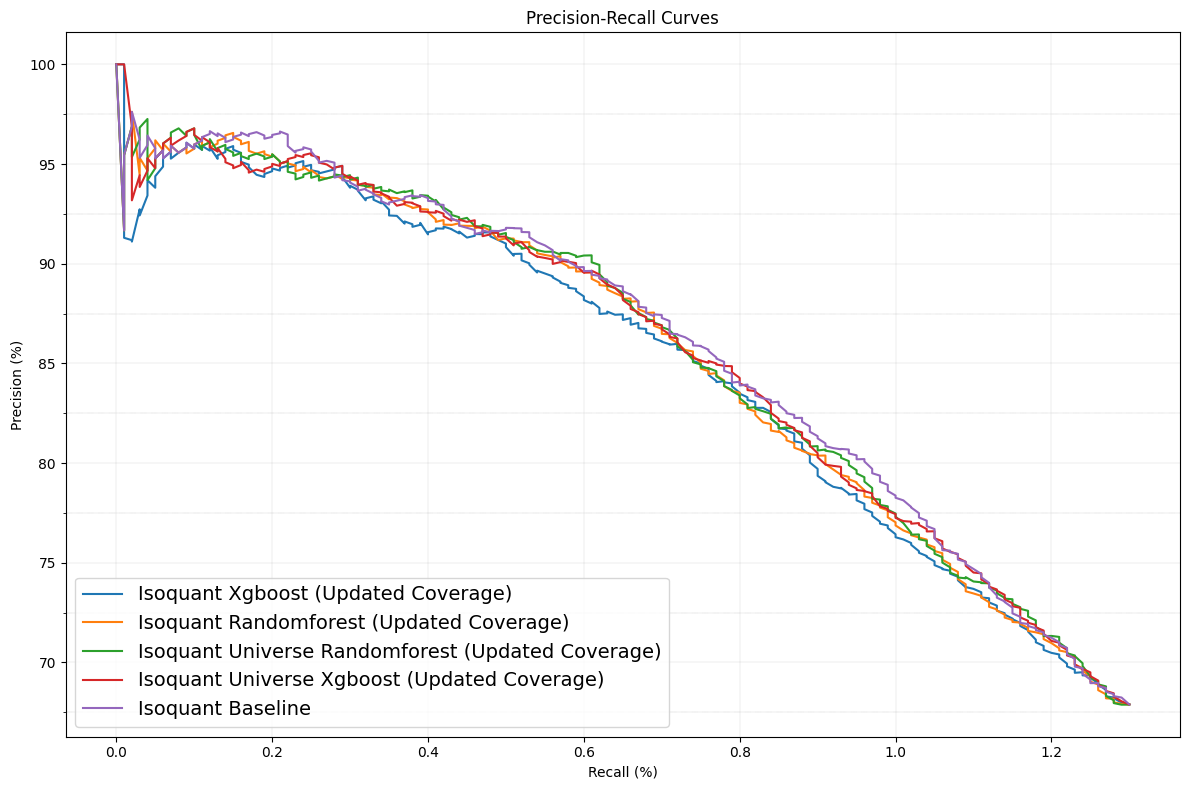

In [7]:
import os
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def plot_pr_curves(folder_path):
    """
    Reads all ROC-like files in the specified folder, parses sensitivity (recall)
    and precision values, and plots Precision-Recall curves for each file.
    """
    plt.figure(figsize=(12, 8))

    # Enable minor ticks and set their spacing
    plt.minorticks_on()
    plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator(1))  # 4 minor intervals per major
    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

    
    # Find all files in the folder
    file_paths = glob.glob(os.path.join(folder_path, '*'))
    
    for file_path in file_paths:
        recalls = []
        precisions = []
        
        with open(file_path, 'r') as f:
            for line in f:
                if line.startswith('ROC:'):
                    # Extract sensitivity and precision values
                    rec_match = re.search(r'sensitivity\s*=\s*([0-9.]+)', line)
                    prec_match = re.search(r'precision\s*=\s*([0-9.]+)', line)
                    if rec_match and prec_match:
                        recalls.append(float(rec_match.group(1)))
                        precisions.append(float(prec_match.group(1)))
        
        # Plot the curve for this file
        label = os.path.basename(file_path)
        label = label.replace('-', ' ').replace('.roc', '').title()
        label = label.replace('Updated Cov', '(Updated Coverage)')
        if "Isoquant" in label or "Isoquant Baseline" in label:
            plt.plot(recalls, precisions, label=label)
    
    # Draw major & minor grid
    plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.3)

    plt.xlabel('Recall (%)')
    plt.ylabel('Precision (%)')
    plt.title('Precision-Recall Curves')
    plt.legend(loc='lower left', fontsize=14)
    plt.grid(True, linewidth=0.1)   
    plt.tight_layout()
    plt.savefig('../out/plots/pacbio_ENCFF694DIE_pr_curves_compare.png')
    # plt.show()

# Replace with the path to your folder containing the ROC files
plot_pr_curves('/datadisk1/ixk5174/long_reads_compare/out/gffcomp-results/pacbio_ENCFF694DIE/updated-cov/roc')
